# 用户行为分析

## 数据预处理

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# matplotlib 设置中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'

DATA_PATH = "UserBehavior.csv"

# 读取数据
df = pd.read_csv(DATA_PATH, header=None, nrows=10000)

# 由于原始数据没有列名信息，进行列名重命名
df.columns = ['user_id', 'product_id', 'category_id', 'behaviour', 'timestamp']

# 处理缺失值
df.dropna(inplace=True)

# 转换时间戳
## 时间戳转换为时间
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s', origin=pd.Timestamp('1970-01-01 08:00:00'))
df['date'] = df['datetime'].dt.date
df['time'] = df['datetime'].dt.time
df['hour'] = df['datetime'].dt.hour
df['weekday'] = df['datetime'].dt.weekday

df['date'].value_counts()

# 发现有异常事件，处理异常时间
df = df[(df['datetime'] >= '2017-11-25 00:00:00') & (df['datetime'] < '2017-12-04 00:00:00')]

## 用户购物情况整体分析

1. 统计访问量、用户数、平均访问量
2. 统计跳失率（跳失率即只有点击行为的用户/总用户数）

In [27]:
PV = df['behaviour'].value_counts()['pv']
UV = len(df['user_id'].unique())
average = PV / UV
print('访问量：{}\n用户数：{}\n平均访问量：{}\n'.format(PV, UV, average))

not_lost_behaviour = ['fav', 'buy', 'cart']
lost_UV = UV - len(df[df['behaviour'].isin(not_lost_behaviour)]['user_id'].unique())
lost_rate = lost_UV / UV

print('在 {} 用户中，有 {} 用户跳失，跳失率为 {: .2f}%'.format(UV, lost_UV, lost_rate * 100))

访问量：8983
用户数：92
平均访问量：97.6413043478261

在 92 用户中，有 8 用户跳失，跳失率为  8.70%


## 用户活跃规律

1. 用户在一天中的活跃情况
2. 用户在一周中的活跃情况
3. 一天不同时段的成交量

### 用户在一天中的活跃情况

<AxesSubplot:xlabel='hour', ylabel='count'>

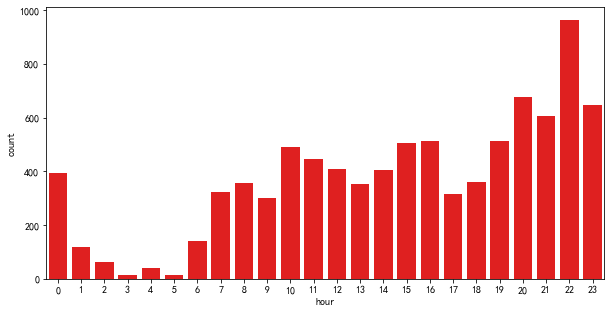

In [28]:
data = df.drop_duplicates(['user_id', 'date'])
df['user_id'].groupby(df['date']).count()

df[df['behaviour'] == 'pv']['behaviour'].groupby(df['date']).count()

plt.figure(figsize=(10, 5))  #调整画布大小
plt.tick_params(labelsize=10)  #调整标签字体大小
sns.countplot(x='hour', data=df[df['behaviour'] == 'pv'], color='red', label='访问量')

### 用户在一周中的活跃情况

<AxesSubplot:title={'center':'用户在一周中的活跃情况'}, xlabel='weekday', ylabel='count'>

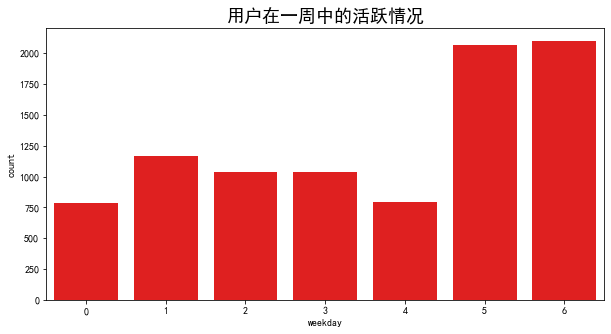

In [29]:
f, ax = plt.subplots(figsize=(10, 5))
ax.tick_params(labelsize=10)
ax.set_title('用户在一周中的活跃情况', fontsize=18)
sns.countplot(x='weekday', data=df[df['behaviour'] == 'pv'], color='red')

### 在一天不同时段的成交量

<AxesSubplot:title={'center':'一天不同时段的成交量'}, xlabel='hour', ylabel='count'>

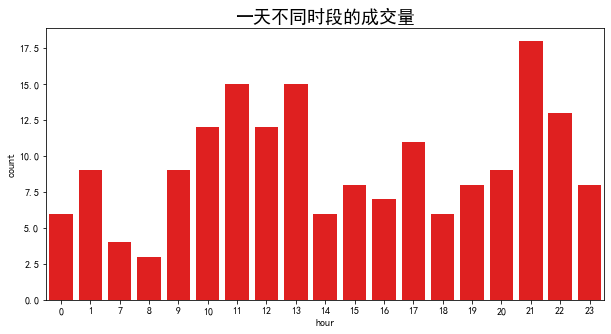

In [30]:
data[data['behaviour'] == 'buy']['behaviour'].groupby(data['hour']).count()
f, ax = plt.subplots(figsize=(10, 5))
ax.tick_params(labelsize=10)
ax.set_title('一天不同时段的成交量', fontsize=18)
sns.countplot(x='hour', data=df[df['behaviour'] == 'buy'], color="red")

## 行为转化漏斗模型

<AxesSubplot:xlabel='count', ylabel='behaviour'>

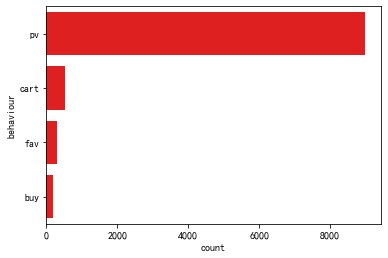

In [31]:
sns.countplot(y='behaviour', data=df, color='red', order=['pv', 'cart', 'fav', 'buy'])

In [32]:
# 每个环节的转化率

# 浏览到加入购物车转化率
data = pd.merge(df[df['behaviour'] == 'pv'], df[df['behaviour'] == 'cart'],
                on=['user_id', 'product_id', 'category_id'])
data = data[data['timestamp_x'] < data['timestamp_y']]
pv2cart = len(data['user_id'].unique()) / len(df[df['behaviour'] == 'pv']['user_id'].unique())

print('浏览到加入购物车转化率：{:.2f}%'.format(pv2cart * 100))

# 浏览到收藏转化率
data = pd.merge(df[df['behaviour'] == 'pv'], df[df['behaviour'] == 'fav'],
                on=['user_id', 'product_id', 'category_id'])  #同一用户同一商品既浏览又收藏数据
data = data[data['timestamp_x'] < data['timestamp_y']]  #同一用户同一商品先浏览再收藏数据
pv2fav = len(data['user_id'].unique()) / len(df[df['behaviour'] == 'pv']['user_id'].unique())  #用户浏览加入收藏的转化率

print('浏览到加入收藏转化率：{:.2f}%'.format(pv2fav * 100))

# 收藏到购买转化率
data = pd.merge(df[df['behaviour'] == 'fav'], df[df['behaviour'] == 'buy'],
                on=['user_id', 'product_id', 'category_id'])
data = data[data['timestamp_x'] < data['timestamp_y']]
fav2buy = len(data['user_id'].unique()) / len(df[df['behaviour'] == 'fav']['user_id'].unique())

print('收藏到购买转化率：{:.2f}%'.format(fav2buy * 100))

浏览到加入购物车转化率：43.48%
浏览到加入收藏转化率：11.96%
收藏到购买转化率：15.15%


## 参照 RFM 模型，对用户进行分类找出有价值的用户

RFM 模型是衡量客户价值和客户创利能力的重要工具。该模型通过客户的最近交易行为（Recency）、交易频率（Frequency）以及交易金额（Monetary）三项指标来描述该客户的价值状况。一般来说，会将这三项指标分成几个区间进行评分，通过计算评分找到有价值的用户，并对用户进行分类。

因为数据源里没有金额相关的信息，所以只通过 R 和 F 来对客户价值进行评分。

In [33]:
data = df[df['behaviour'] == 'buy']  #购买数据
data['day_past'] = np.floor((df['timestamp'] - 1511539200) / (60 * 60 * 24))  #购买日期离2017年11月25日的天数


def count_recency(n):
    if n in [0, 1, 2]:
        return 1
    elif n in [3, 4]:
        return 2
    elif n in [5, 6]:
        return 3
    else:
        return 4


data['recency'] = data['day_past'].map(lambda x: count_recency(x))

recency_data = data.drop_duplicates(['user_id'])


def count_frequency(n):
    if 1 <= n <= 21:
        return 1
    elif 22 <= n <= 42:
        return 2
    elif 43 <= n <= 63:
        return 3
    else:
        return 4


repurchase_data = pd.DataFrame(data['user_id'].value_counts())
repurchase_data.columns = ['repurchase_count']
repurchase_data['user_id'] = repurchase_data.index
data = pd.merge(repurchase_data, data, on='user_id')

data['frequency'] = data['repurchase_count'].map(lambda x: count_frequency(x))

### 分析

对用户进行分类

In [34]:
recency_avg = data['recency'].mean()
frequency_avg = data['frequency'].mean()
print('平均最近购买等级：{}\n平均购买频率等级：{}'.format(recency_avg, frequency_avg))

data['user_category'] = np.select([
    (data['recency'] > recency_avg) & (data['frequency'] > frequency_avg),
    (data['recency'] > recency_avg) & (data['frequency'] <= frequency_avg),
    (data['recency'] <= recency_avg) & (data['frequency'] > frequency_avg),
    (data['recency'] <= recency_avg) & (data['frequency'] <= frequency_avg)],
    ['重要价值用户', '重要保持用户', '重要发展用户', '一般价值用户'])

level1 = len(data[data['user_category'] == '重要价值用户'])
level2 = len(data[data['user_category'] == '重要保持用户'])
level3 = len(data[data['user_category'] == '重要发展用户'])
level4 = len(data[data['user_category'] == '一般价值用户'])

print('重要价值用户数量：{}\n重要保持用户数量：{}\n重要发展用户数量：{}\n一般价值用户数量：{}\n'.format(level1, level2, level3, level4))

平均最近购买等级：2.3128491620111733
平均购买频率等级：1.0
重要价值用户数量：0
重要保持用户数量：71
重要发展用户数量：0
一般价值用户数量：108



## 基于用户的协同过滤和基于项目的协同过滤

In [37]:
n_users = df['user_id'].unique().shape[0]
n_items = df['product_id'].unique().shape[0]
from sklearn import model_selection as cv

df['tight_user_id'] = pd.Series()
df['tight_product_id'] = pd.Series()

user_id_count = 0
product_id_count = 0


def count_user_id(x):
    global user_id_count
    x['tight_user_id'] = user_id_count
    user_id_count += 1
    return x


def count_product_id(x):
    global product_id_count
    x['tight_product_id'] = product_id_count
    product_id_count += 1
    return x


df = df.groupby('user_id').apply(count_user_id)
df = df.groupby('product_id').apply(count_product_id)

print(df)

train_data, test_data = cv.train_test_split(df, test_size=0.2)


def count_rate(behaviour):
    if behaviour == 'pv':
        return 1
    elif behaviour == 'fav' or behaviour == 'cart':
        return 2
    elif behaviour == 'buy':
        return 4
    else:
        return 1


#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[-2], line[-1]] = count_rate(line[4])
test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[-2], line[-1]] = count_rate(line[4])
# 你可以使用 sklearn 的 pairwise_distances 函数来计算余弦相似性。注意，因为评价都为正值输出取值应为0到1.
from sklearn.metrics.pairwise import pairwise_distances

user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')


def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array(
            [np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred


item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

# 用于评估预测精度最流行的指标之一是 Root Mean Squared Error (RMSE)。
from sklearn.metrics import mean_squared_error
from math import sqrt


def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()  #nonzero(a)返回数组a中值不为零的元素的下标,相当于对稀疏矩阵进行提取
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))


print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

<ipython-input-37-a44910a8f2ce>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['tight_user_id'] = pd.Series()
<ipython-input-37-a44910a8f2ce>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['tight_product_id'] = pd.Series()


      user_id  product_id  category_id behaviour   timestamp  \
0           1     2268318      2520377        pv  1511544070   
1           1     2333346      2520771        pv  1511561733   
2           1     2576651       149192        pv  1511572885   
3           1     3830808      4181361        pv  1511593493   
4           1     4365585      2520377        pv  1511596146   
...       ...         ...          ...       ...         ...   
9995  1000436     2279117       405755        pv  1512184711   
9996  1000436     1542569      3619575       buy  1512184723   
9997  1000436     2279117       405755        pv  1512184785   
9998  1000436     3249912      2920476        pv  1512184868   
9999  1000436      921462      1888306       fav  1512184965   

                datetime        date      time  hour  weekday  tight_user_id  \
0    2017-11-25 01:21:10  2017-11-25  01:21:10     1        5              0   
1    2017-11-25 06:15:33  2017-11-25  06:15:33     6        5          